# Visualizing Household Energy Consumption

## 1. The Dataset
Submetering allows to record energy consumption in specific areas of a house. Herein, a dataset will be analyzed, which contains the collection of electricity consumption measurements by three submeters placed in different zones of a house in Sceaux, a town located near Paris. This is an open dataset freely available at this [url](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption#).  <br> The purpose of this analysis is to show how energy consumption patterns in different areas of a residential unit can be gleaned from data collected by submeters. This technology would thus enable more efficient energy delivery, while simultaneously providing customers with information about their consumption patterns that may incentivize them to save energy. In summary, the following analysis supports the case for widespread adoption of submetering technology. <br>  
__Time range of recorded measurements__: from December 2006 to November 2010 (47 months). <br>
__Locality__: Sceaux, Paris, France. <br>
__Sampling rate__: 1 minute. <br>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

Load dataset. 

In [2]:
file_path = "./household_power_consumption.csv"
cons = pd.read_csv(file_path, sep=";")

/Users/Giacomo/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Some columns contain observations having different data types. 

In [3]:
cons.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


The meaning and measurement units of each variable as reported on the dataset description are: <br>
* __Global_active_power__ : household global minute-averaged active power (kW). <br>
* __Global_reactive_power__ : household global minute-averaged reactive power (kW). <br>
* __Voltage__ : minute-averaged voltage (V). <br>
* __Global_intensity__ : minute-averaged current (A). <br>
* __Sub_metering_1__ : energy sub-metering No. 1 (in Wh). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). <br>
* __Sub_metering_2__ : energy sub-metering No. 2 (in Wh). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. <br>
* __Sub_metering_3__ : energy sub-metering No. 3 (in Wh). It corresponds to an electric water-heater and an air-conditioner.

A glance at the size of the dataset. 

In [4]:
cons.shape

(2075259, 9)

Rename features using shorter names. 

In [5]:
names = ["date", 
         "time", 
         "active_pow", 
         "reactive_pow", 
         "voltage", 
         "current", 
         "sub1", 
         "sub2", 
         "sub3" ]

# dict with old and new names
d_names = {}
for old_name, new_name in zip(cons.columns, names):
    d_names.update({old_name: new_name})
    
# replace old feature names
cons.rename(mapper= d_names, axis=1, inplace=True)
cons.head()

,date,time,active_pow,reactive_pow,voltage,current,sub1,sub2,sub3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## 2. Cleaning and Reorganizing the Data

Check for missing values. 

In [6]:
cons.isna().sum()

date                0
time                0
active_pow          0
reactive_pow        0
voltage             0
current             0
sub1                0
sub2                0
sub3            25979
dtype: int64

In [7]:
cons[ cons.isna().any(axis= 1) ].head()

,date,time,active_pow,reactive_pow,voltage,current,sub1,sub2,sub3
6839,21/12/2006,11:23:00,?,?,?,?,?,?,NaN
6840,21/12/2006,11:24:00,?,?,?,?,?,?,NaN
19724,30/12/2006,10:08:00,?,?,?,?,?,?,NaN
19725,30/12/2006,10:09:00,?,?,?,?,?,?,NaN
41832,14/1/2007,18:36:00,?,?,?,?,?,?,NaN


Some observations for submeter 3 contain missing values (about 1.25%); these values are associated with "?" strings for the other features, hence the mismatch of data types that raised an error when loading the dataset. <br>
A quick check on the data types reveals that all columns but the last one were loaded as strings: 

In [8]:
# check dtypes
cons.dtypes

date             object
time             object
active_pow       object
reactive_pow     object
voltage          object
current          object
sub1             object
sub2             object
sub3            float64
dtype: object

The quantitative variables - except for dates and times that will serve as the index of the time series - can be converted from *object* to *float64* types. The option "errors= 'coerce'" will assign to NaN any strings that cannot be successfully parsed and converted to a number by pandas. 

In [9]:
# update dtypes
float_list = list(cons.columns[2:-1])
for col in float_list: 
    cons[ col ] = pd.to_numeric( cons[col], errors= "coerce" )
cons.isna().sum()

date                0
time                0
active_pow      25979
reactive_pow    25979
voltage         25979
current         25979
sub1            25979
sub2            25979
sub3            25979
dtype: int64

Next, missing values are removed from the dataset as they make up a small part of it, and stored in a separate data frame. 

In [10]:
na_cons = cons[ cons.isna().any(axis= 1) ].copy()
cons_nona = cons.dropna(axis= 0).copy()

In [11]:
cons_nona.dtypes

date             object
time             object
active_pow      float64
reactive_pow    float64
voltage         float64
current         float64
sub1            float64
sub2            float64
sub3            float64
dtype: object

The following steps will reorganize a bit the dataset: <br>
* date and time are merged into a single feature "date_time". <br>
* "date_time" feature will be the time series index. It is moved to first column, while "date" and "time" columns are dropped. <br>
* the amount of consumed energy not measured by the submeters can be calculated and added to the data frame: <br>  

---
**RESIDUAL ENERGY**
          $$\text{residual energy} = (\text{total active power})*1000/60 - (\text{submeter 1}) - (\text{submeter 2}) - (\text{submeter 3})$$
          
---
  this amount is added as last column "res". 

In [12]:
cons_nona["date_time"] = cons_nona.loc[:, "date"] + " " + cons_nona.loc[:, "time"]
cols = cons_nona.columns.tolist()
col_reorder = ["date_time"] + cols[:-1]
cons_nona = cons_nona[col_reorder]
#cons_nona = cons_nona.drop(["date", "time"], axis= 1)
cons_nona["res"] = (cons_nona.loc[:, "active_pow"]*1e3/60 - 
                    cons_nona.loc[:, "sub1"] - 
                    cons_nona.loc[:, "sub2"] - 
                    cons_nona.loc[:, "sub3"])
cons_nona.head()

,date_time,date,time,active_pow,reactive_pow,voltage,current,sub1,sub2,sub3,res
0,16/12/2006 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
1,16/12/2006 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2,16/12/2006 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
3,16/12/2006 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,16/12/2006 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


Finally, set "date_time" to object of type "Timestamp" using pandas and Python's Datetime library. 

In [13]:
cons_nona["date_time"] = pd.to_datetime(cons_nona["date_time"],  
                                        dayfirst= True, 
                                        infer_datetime_format= True)
cons_nona.dtypes

date_time       datetime64[ns]
date                    object
time                    object
active_pow             float64
reactive_pow           float64
voltage                float64
current                float64
sub1                   float64
sub2                   float64
sub3                   float64
res                    float64
dtype: object

And set "date_time" as time series index of the dataset. 

In [14]:
cons_nona = cons_nona.set_index("date_time")

## 3. Exploratory Analysis of the Time Series

The dataset includes 8 quantitative features. Histograms can be used to get an overview of the energy consumption distribution over the whole timespan of the recorded data. <br>

In [15]:
cons_nona.head()

,date,time,active_pow,reactive_pow,voltage,current,sub1,sub2,sub3,res
date_time,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


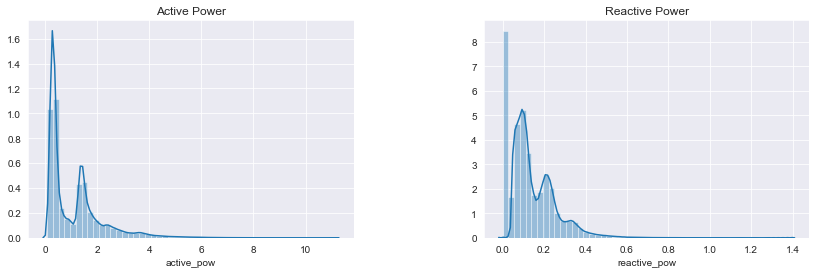

In [16]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 2, figsize= (14, 4))
plt.subplots_adjust(wspace= 0.4, hspace= 0.4)

title = ["Active Power", "Reactive Power"]
to_plot = [cons_nona[ "active_pow" ], cons_nona[ "reactive_pow" ] ]

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    sns.distplot(to_plot[i])

Both active and reactive power show a clear multimodal distribution of values. <br>
* The most frequent active power consumption values occur between 0 and 1 kW, and between 1 and 2 kW. However, the tail of the distribution extends well beyond 2 kW. Active power can occasionally reach magnitudes much higher than the median. <br>
* The most frequent reactive power consumption values occur below 0.4 kW. Note that the scale of the reactive power consumed by the household is about 10% that of the active one. <br> 

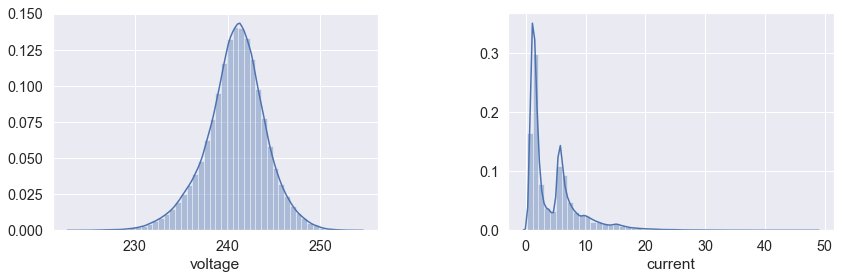

In [17]:
fig, axes = plt.subplots(1, 2, figsize= (14, 4))
plt.subplots_adjust(wspace= 0.4, hspace= 0.4)
sns.set(font_scale= 1.3)

title = ["Voltage", "Current"]
to_plot = [cons_nona[ "voltage" ], cons_nona[ "current" ] ]

for i in range(2): 
    plt.subplot(1, 2, i+1)
    sns.distplot(to_plot[i])

The distributions of current and voltage are not so informative: <br>
* The (rms) voltage is approximately constant as the power source provides a constant voltage drop at the outlets. <br>
* The (rms) current is proportional to the total power consumed by the household, therefore the histogram is the same. 

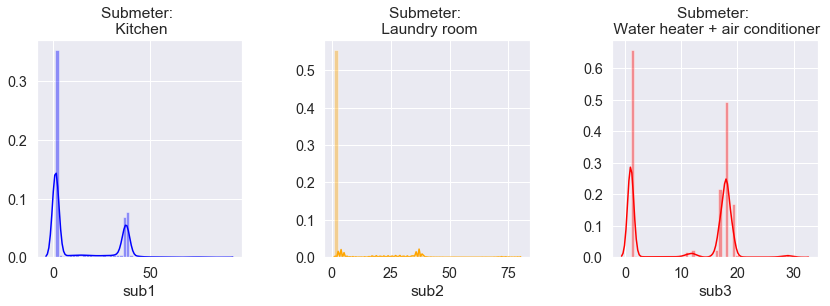

In [18]:
# histograms are plotted after removing null values
fig, axes = plt.subplots(1, 3, figsize= (14, 4))
plt.subplots_adjust(wspace= 0.4, hspace= 0.4)

sub1_meas = cons_nona[ cons_nona["sub1"]>0 ].sub1
sub2_meas = cons_nona[ cons_nona["sub2"]>0 ].sub2
sub3_meas = cons_nona[ cons_nona["sub3"]>0 ].sub3

to_plot = [ sub1_meas, sub2_meas, sub3_meas ]
colors = ["blue", "orange", "red"]
title = ["Submeter: \n Kitchen", 
         "Submeter: \n Laundry room", 
         "Submeter: \n Water heater + air conditioner"]

for i in range(3): 
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    sns.distplot(to_plot[i], color= colors[i])    

Energy consumption measured by submeters reveals frequency spikes for low energy values (< 2 Wh) and for some high energy values (30-40 Wh for submeter 1 and 2, 15-20 Wh for submeter 3). Values in between these regions occur much less frequently, and are spread over a broad energy interval. 

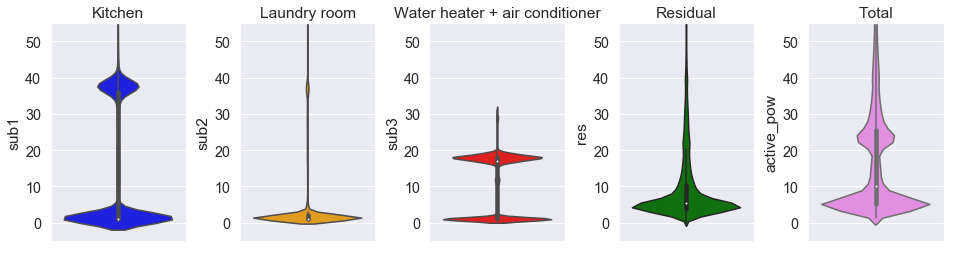

In [19]:
fig, axes = plt.subplots(1, 5, figsize= (16, 4))
plt.subplots_adjust(wspace= 0.4, hspace= 0.4)

res = cons_nona[ cons_nona["res"]>0 ].res
tot = cons_nona[ cons_nona["active_pow"]>0 ].active_pow
y = [ sub1_meas, sub2_meas, sub3_meas, res, tot*1000/60 ]
colors = ["blue", "orange", "red", "green", "violet"]
title = ["Kitchen", 
         "Laundry room", 
         "Water heater + air conditioner", 
         "Residual", "Total"]

for i in range(5): 
    plt.subplot(1, 5, i+1)
    plt.title(title[i])
    plt.ylim(-5, 55)
    sns.violinplot(y= y[i], color= colors[i])

The above conclusions are clearly displayed using violin plots. <br>
* Kitchen appliances, and the water heater and air conditioner cause frequent spikes in energy consumption.

In [20]:
# some statistics on power usage measured by submeters
tot_meas = len(cons_nona)
power_usage_sub1 = len(sub1_meas)/tot_meas*100
print("Time that submeters record non-zero energy consumption, as a fraction of total time:")
print("For kitchen appliances: {:.2f}".format(power_usage_sub1), "%")
power_usage_sub2 = len(sub2_meas)/tot_meas*100
print("For laundry room appliances: {:.2f}".format(power_usage_sub2), "%")
power_usage_sub3 = len(sub3_meas)/tot_meas*100
print("For water heater and air conditioner: {:.2f}".format(power_usage_sub3), "%")

Time that submeters record non-zero energy consumption, as a fraction of total time:
For kitchen appliances: 8.25 %
For laundry room appliances: 29.89 %
For water heater and air conditioner: 58.42 %


In summary: <br>
* Kitchen appliances are the least frequently used. Laundry appliances come second place, followed by the water heater and air conditioner which are the most frequently used. 

Energy consumption can be resampled over longer time intervals using the time series index of the data frame: hours, days, weeks, months. 

In [21]:
# resample energy consumption over time: 
# calculate average over hours, days, weeks, months
# fillna(method= "pad"): fill Na values due to daylight saving time (day length != 24 h) with latest available value
byHour = cons_nona.resample("H").mean().fillna(method= "pad")
byDay = cons_nona.resample("D").mean().fillna(method= "pad")
byWeek = cons_nona.resample("W").mean().fillna(method= "pad")
byMonth = cons_nona.resample("M").mean().fillna(method= "pad")

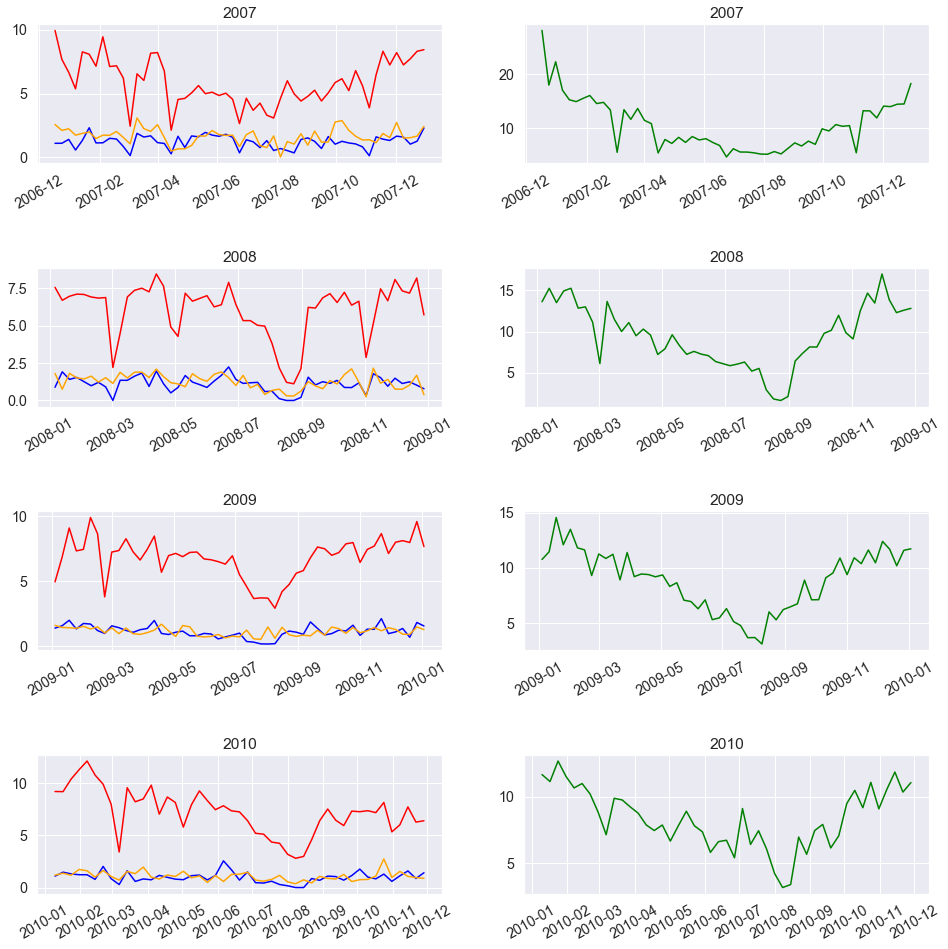

In [22]:
fig, axes = plt.subplots(4, 2, figsize= (16, 16))
plt.subplots_adjust(hspace= 0.75)

plot_n = [[1, 2], [3, 4], [5, 6], [7, 8]]
years = [byWeek.index[0:55], 
         byWeek.index[55:107], 
         byWeek.index[107:160], 
         byWeek.index[160:207]]
titles = ["2007", "2008", "2009", "2010"]

for i in range(4): 
    for j in range(2): 
        plt.subplot(4, 2, plot_n[i][j])
        plt.xticks(rotation= 30)
        plt.title(titles[i])
        if j%2==0: 
            axes[i, j]= plt.plot(byWeek.loc[ years[i], "sub1"], c= "blue")
            axes[i, j]= plt.plot(byWeek.loc[ years[i], "sub2"], c= "orange")
            axes[i, j]= plt.plot(byWeek.loc[ years[i], "sub3"], c= "red")
        else: 
            axes[i, j]= plt.plot(byWeek.loc[ years[i], "res"], c= "green")

Plotting the average energy consumed per week over the years reveals interesting patterns: <br>
* By far, the largest amount of energy is consumed by the appliances monitored by submeter 3 (red line): __the water heater and the air conditioner__. These consume on average more than twice as much energy as the other appliances recorded by submeters 1 and 2 combined. <br>
* The energy consumed by the water heater and the air conditioner also shows __large seasonal variations__: it decreases and reaches a minimum during the summer months, particularly in August, likely as a result of vacation time being spent out of the house by the family members. <br>
* Similar large seasonal variations are observed for the energy of appliances not monitored by submeters (green line).
* Seasonal variations are also present in energy consumption measured by the other submeters, but the absolute scale is small compared with the energy measured by submeter 3. 

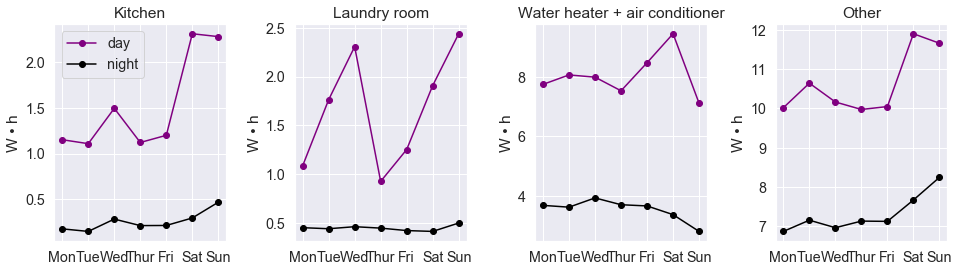

In [23]:
fig, axes = plt.subplots(1, 4, figsize= (16, 4))
plt.subplots_adjust(wspace= 0.4)

# daily and nighttime consumption
daily_consumption = byHour.between_time("07:00", "23:00").resample("D").mean()
night_consumption = byHour.between_time("23:00", "07:00").resample("D").mean()

quantity = ["sub1", "sub2", "sub3", "res"]
titles = ["Kitchen", "Laundry room", "Water heater + air conditioner", "Other"]
labels = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]

for i in range(4): 
    plt.subplot(1, 4, i+1)
    plt.ylabel("W • h")
    plt.rc('font', size= 14)
    axes[i] = plt.plot(daily_consumption.loc[:, quantity[i]].groupby(daily_consumption.index.dayofweek).mean(), 
              marker= ".", markersize= 12, c= "purple")
    axes[i] = plt.xticks(np.arange(7), labels)
    axes[i] = plt.plot(night_consumption.loc[:, quantity[i]].groupby(night_consumption.index.dayofweek).mean(), 
              marker= ".", markersize= 12, c= "black")
    axes[i] = plt.xticks(np.arange(7), labels)
    axes[i] = plt.title(titles[i])
    if i==0: axes[i] = plt.legend(labels=["day", "night"])

Important insights into energy consumption patterns can be gained by considering the intra-day and weekly variations of submeter readings: <br>
* __Daytime__ energy consumption (from 7 am to 11 pm) is much greater than - and often at least twice as much as - __nighttime__ consumption. 
* A larger amount of energy is generally utilized __during the weekend__. 
* Average energy consumption is quite consistent over the weekdays; an exception is the laundry room consumption, where two weekdays show average consumption above normal, close to that recorded on weekends. 

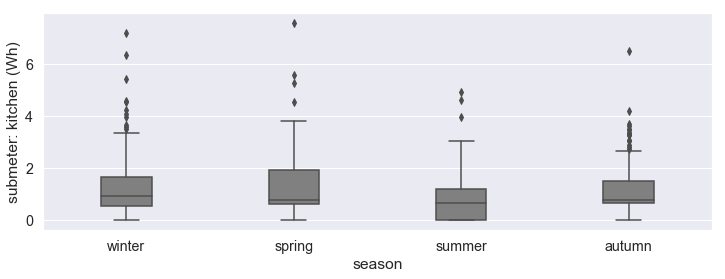

In [24]:
winter = []
spring = []
summer = []
autumn = []

start = ["2006-12-23", "2007-12-23", "2008-12-23", "2009-12-23"]
end= ["2007-03-21", "2008-03-21", "2009-03-21", "2010-03-21"]
for i in range(4): 
    winter.append(pd.date_range(start= start[i], end= end[i]))
# winters
for i in range(1, 4): 
    winter_df = byDay.loc[winter[0], :].append(byDay.loc[winter[i], :])

start = ["2007-03-21", "2008-03-21", "2009-03-21", "2010-03-21"]
end= ["2007-06-21", "2008-06-21", "2009-06-21", "2010-06-21"]
for i in range(4): 
    spring.append(pd.date_range(start= start[i], end= end[i]))
# springs
for i in range(1, 4): 
    spring_df = byDay.loc[spring[0], :].append(byDay.loc[spring[i], :])

start = ["2007-06-23", "2008-06-23", "2009-06-23", "2010-06-23"]
end= ["2007-09-22", "2008-09-22", "2009-09-22", "2010-09-22"]
for i in range(4): 
    summer.append(pd.date_range(start= start[i], end= end[i]))
# summers
for i in range(1, 4): 
    summer_df = byDay.loc[summer[0], :].append(byDay.loc[summer[i], :])

start = ["2007-09-24", "2008-09-24", "2009-09-24", "2010-09-24"]
end= ["2007-12-22", "2008-12-22", "2009-12-22", "2010-12-22"]
for i in range(4): 
    autumn.append(pd.date_range(start= start[i], end= end[i]))
# autumns
for i in range(1, 4): 
    autumn_df = byDay.loc[autumn[0], :].append(byDay.loc[autumn[i], :])
    
colors = ["blue", "orange", "red", "green"]
labels = ["Winter Consumption -\n Submeter 1", 
          "Spring Consumption -\n Submeter 1", 
          "Summer Consumption -\n Submeter 1", 
          "Autumn Consumption -\n Submeter 1"]

winter_df["season"] = "winter"
spring_df["season"] = "spring"
summer_df["season"] = "summer"
autumn_df["season"] = "autumn"

seasons = pd.concat([winter_df, spring_df, 
                     summer_df, autumn_df])

fig, ax = plt.subplots(1, 1, figsize= (12, 4))

ax = sns.boxplot(x= seasons.season, 
                y= seasons.sub1, 
                orient= "v", 
                width= 0.3, 
                color= "grey")
ax = ax.set_ylabel("submeter: kitchen (Wh)")
plt.rc('font', size= 14)

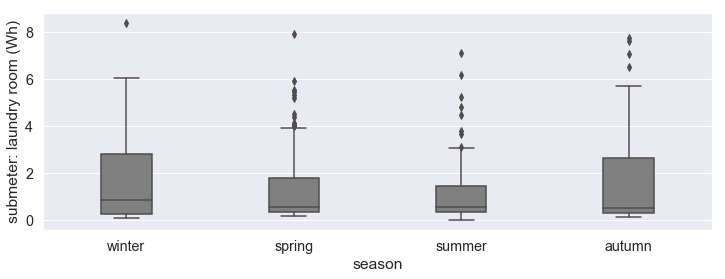

In [25]:
fig, ax = plt.subplots(1, 1, figsize= (12, 4))

ax = sns.boxplot(x= seasons.season, 
                y= seasons.sub2, 
                orient= "v", 
                width= 0.3, 
                color= "grey")
ax = ax.set_ylabel("submeter: laundry room (Wh)")
plt.rc('font', size= 14)

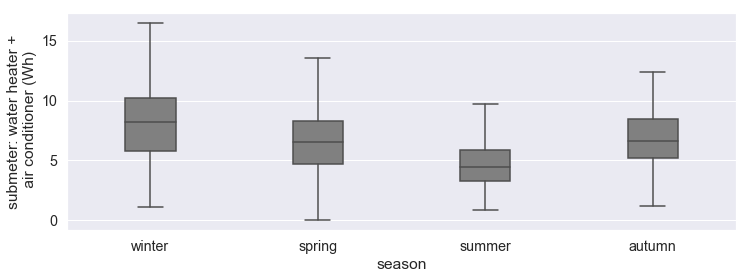

In [26]:
fig, ax = plt.subplots(1, 1, figsize= (12, 4))

ax = sns.boxplot(x= seasons.season, 
                y= seasons.sub3, 
                orient= "v", 
                width= 0.3, 
                color= "grey")
ax = ax.set_ylabel("submeter: water heater +\n air conditioner (Wh)")
plt.rc('font', size= 14)

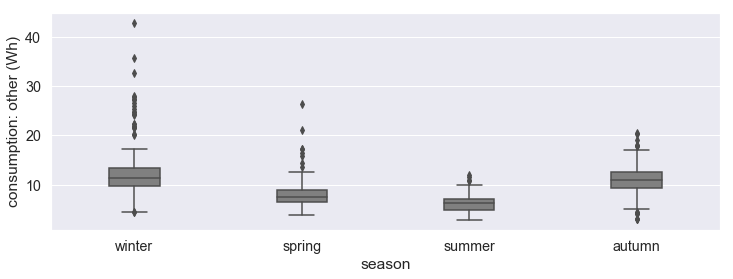

In [27]:
fig, ax = plt.subplots(1, 1, figsize= (12, 4))

ax = sns.boxplot(x= seasons.season, 
                y= seasons.res, 
                orient= "v", 
                width= 0.3, 
                color= "grey")
ax = ax.set_ylabel("consumption: other (Wh)")
plt.rc('font', size= 14)

Seasonal variations analyzed via boxplots: 

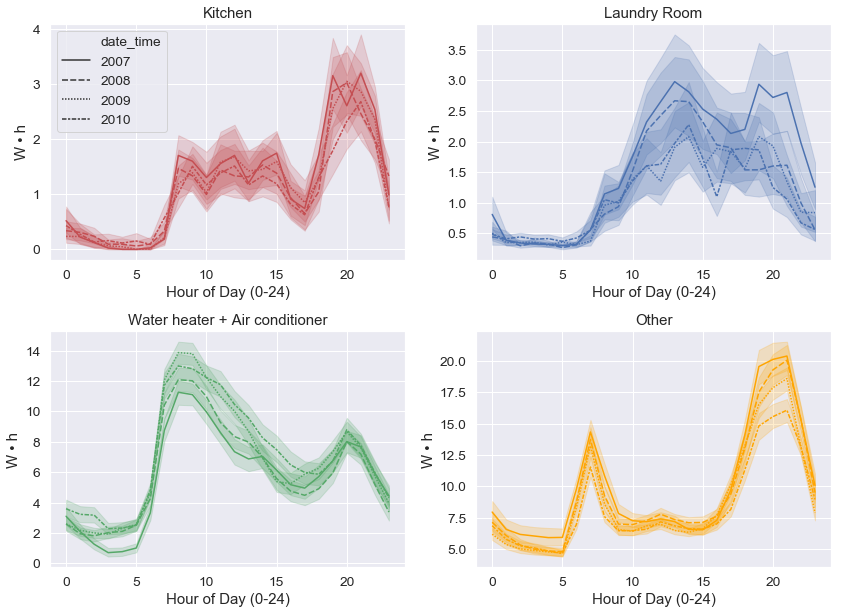

In [28]:
# hourly mean energy consumed over a day
# break down data by year (excluding last days of 2006). 
fig, axes = plt.subplots(2, 2, figsize= (14, 10))
plt.subplots_adjust(hspace= 0.3)
sns.set(font_scale= 1.25)

plot_n = [ [1, 2], [3, 4] ]
period_to_plot = byHour.loc["2007-01-01":, :]
quantity = [["sub1", "sub2"], ["sub3", "res"]]
colors = [["r", "b"], ["g", "orange"]]
titles = [["Kitchen", "Laundry Room"], ["Water heater + Air conditioner", "Other"]]

for i in range(2): 
    for j in range(2): 
        plt.subplot(2, 2, plot_n[i][j])
        if i==0 and j==0: 
            axes[i, j] = sns.lineplot(y= period_to_plot.loc[:, quantity[i][j]], 
                                      x= period_to_plot.index.hour, 
                                      style= period_to_plot.index.year, 
                                      color= colors[i][j])
        else: 
            axes[i, j] = sns.lineplot(y= period_to_plot.loc[:, quantity[i][j]], 
                                      x= period_to_plot.index.hour, 
                                      style= period_to_plot.index.year, 
                                      color= colors[i][j], 
                                      legend= False)
        axes[i, j] = plt.xlabel("Hour of Day (0-24)")
        axes[i, j] = plt.ylabel("W • h")
        axes[i, j] = plt.title(titles[i][j])

Intra-day variations analyzed more in detail. 

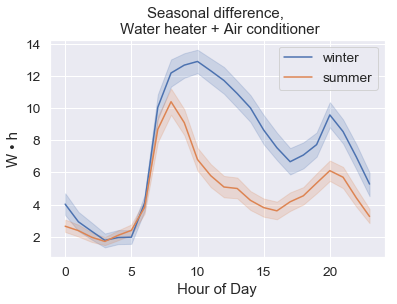

In [29]:
# energy consumption by season
winter = pd.concat( [byHour["2006-12-21":"2007-03-20"], 
                     byHour["2007-12-21":"2008-03-20"], 
                     byHour["2008-12-21":"2009-03-20"], 
                     byHour["2009-12-21":"2010-03-20"]] )

summer = pd.concat( [byHour["2007-06-21":"2007-09-22"], 
                     byHour["2008-06-21":"2008-09-22"], 
                     byHour["2009-06-21":"2009-09-22"], 
                     byHour["2010-06-21":"2010-09-22"]] )

ax= sns.lineplot(x= winter.index.hour, 
                 y= winter.sub3)
ax= sns.lineplot(x= summer.index.hour, 
                 y= summer.sub3)
ax= plt.ylabel("W • h")
ax= plt.xlabel("Hour of Day")
ax= plt.title("Seasonal difference, \n Water heater + Air conditioner")
ax= plt.legend(labels= ["winter", "summer"])

## 4. Time Series Modeling

### 4.1 Time Series Decomposition, Autocorrelation Functions, and modeling with ARIMA.

The `statsmodels` library contains several tools for statistical model building and validation; we can use these to build a model for the household energy consumption time series, and make predictions on the future consumption trend. <br>
We can think of building a model that predicts the average energy consumption on the scale of days, e.g. one month into the future. We start by reducing the granularity of the data by taking the average daily consumption, and focus on the energy consumed by the kitchen appliances monitored by submeter 1.

In [30]:
# load libraries
# time series decomposition 
from statsmodels.tsa.seasonal import seasonal_decompose
# stationarity test 
from statsmodels.tsa.stattools import adfuller
# calculate and plot the autocorrelation functions
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# seasonal ARIMA model 
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

For instance, data for six months starting from September 2009 can be used to fit a seasonal ARIMA model and predict consumption for the month of April 2010. 

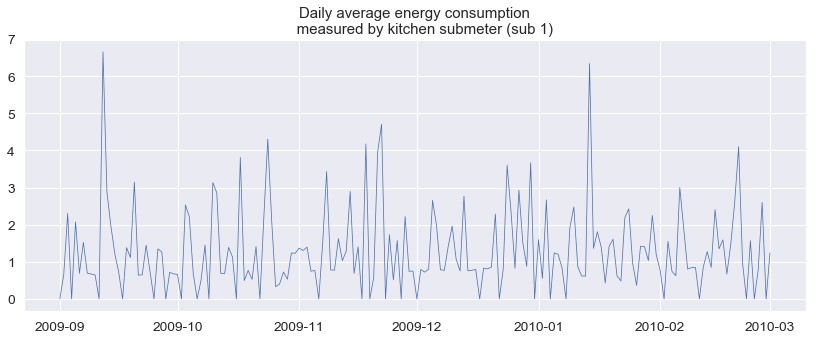

In [31]:
# time series: consumption measured by kitchen submeter
ts = byDay["2009-09-01":"2010-03-01"].sub1.copy()
# set index frequency as daily
ts = ts.asfreq("D")
# plot time series
fig, ax = plt.subplots(figsize= (14, 5))
ax = plt.plot(ts, linewidth= 0.75)
ax = plt.title('''Daily average energy consumption
     measured by kitchen submeter (sub 1)''')

A common method to analyze a time series is via decomposition into three main components that capture the series' most important characteristics: <br>
* __Trend__: change of the level (average value) of the series over time. 
* __Seasonality__: variations that show a pattern over fixed time periods. 
* __Irregular component (aka noise)__: irregular (unpredictable) variations with no detectable pattern.<br>  

Decomposing the series allows to detect any periodicity of the data that is not immediately visible in the plot above. We can perform the split with `statsmodels`, which produces the following charts. 

In [32]:
def split_and_plot(timeseries, split_type, add_observed= True): 
    
    ''' Decomposition of timeseries into trend, seasonality, 
        and residuals. Plotting the three components including
        timeseries observations. '''
    
    ts_decomp = seasonal_decompose(timeseries, model= split_type)
    
    d = { "Observed vs. Trend": (ts_decomp.trend, "orange", 0), 
          "Seasonal Component": (ts_decomp.seasonal, "black", 1), 
          "Residuals": (ts_decomp.resid, "red", 2) }
    
    fig, axes = plt.subplots(3, 1, figsize= (14, 8))
    plt.subplots_adjust(hspace= 1.0)
    
    for key, value in d.items(): 
        plt.subplot(3, 1, value[2]+1)
        
        if add_observed and key=="Observed vs. Trend": 
            axes[value[2]] = plt.plot(timeseries, c= "grey")
            axes[value[2]] = plt.plot(value[0], c= value[1])
            axes[value[2]] = plt.title(key)
        else:         
            axes[value[2]] = plt.plot(value[0], c= value[1])
            axes[value[2]] = plt.title(key)        

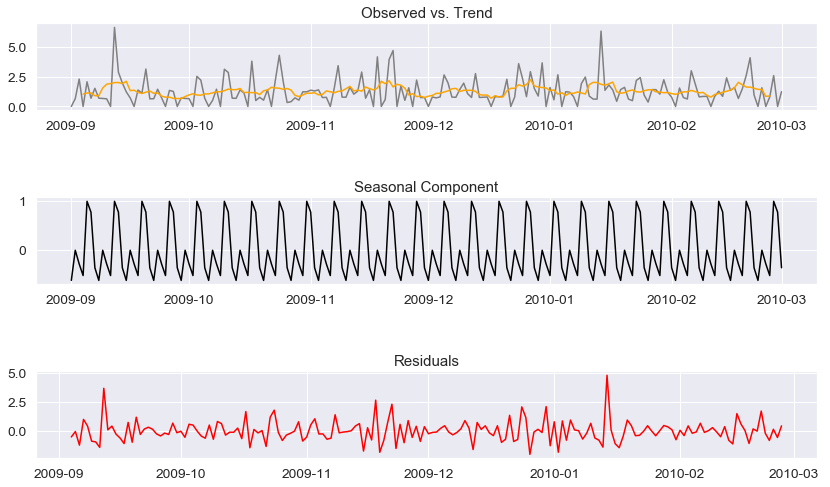

In [33]:
split_and_plot(ts, split_type= "additive")

The sesonal component points to a strong weekly periodicity in the energy consumption, as observed previously upon plotting the average consumption per day of the week. <br>
Next, we can attempt to fit the the series, make predictions for March 2010 and compare these to the actual consumption values.

In [34]:
def plot_autocorr(timeseries, nlags): 
    
    ''' Calculation of timeseries autocorrelation and
        partial autocorrelation function, and plotting. '''
    
    timeseries.dropna(inplace= True)
    
    fig, axes = plt.subplots(1, 2, figsize= (12, 4))
    plt.subplots_adjust(wspace= 0.5)
    
    lag_acf = acf(timeseries, nlags= nlags)
    lag_pacf = pacf(timeseries, nlags= nlags, method= "ols")
    
    fig = plot_acf(timeseries, lags= nlags, ax= axes[0])
    fig = plot_pacf(timeseries, lags= nlags, ax= axes[1])

A look at the autocorrelation and partial autocorrelation functions for the series and for the differenced series (seasonal lag as well as order 1 lag differenced series) will help select the model order, i.e. the parameters for the autoregressive component, the moving average component, and the seasonal component of the model. 

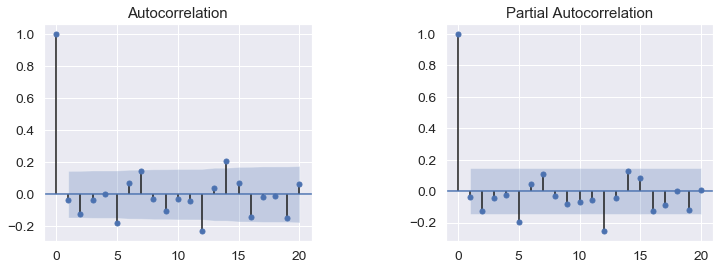

In [35]:
# autocorrelations for the pristine series
plot_autocorr(ts, nlags= 20)

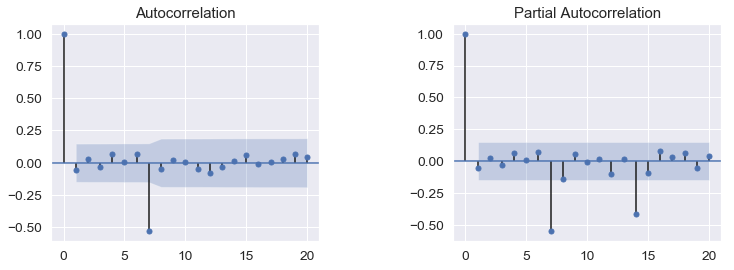

In [36]:
# differenced series
ts_seas_d = ts - ts.shift(7)
# autocorrelations for the differenced series
plot_autocorr(ts_seas_d, nlags= 20)

Taking the difference with lag equal to the seasonality of the series (7 days) shows the presence of a strong lag-7 component in the autocorrelation function (ACF), and the lag-7 + lag-14 components in the partial autocorrelation (PACF). This pattern suggests to fit the seasonal ARIMA model with seasonal parameters P = 2 and Q = 1. 

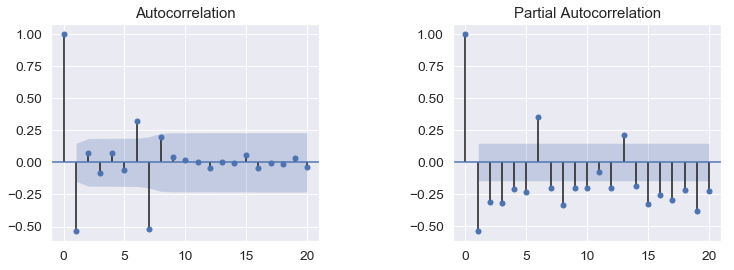

In [37]:
# calculate seasonal shift 
ts_d1 = ts_seas_d - ts_seas_d.shift(1)
plot_autocorr(ts_d1, nlags= 20)

The 1-differenced series is calculated by subtracting the one-day lagged series from the pristine one, and represents the time difference between each pair of instances. Its ACF shows a negative correlation at lag 1, followed by an abrupt drop which is indicative of a temporal process dominated by a moving average 1 component, or MA(1). Using this information as well as the PACF pattern, we will fit the model with nonseasonal order parameters p = 1 and q = 1. 

Finally, the degree of stationarity of the differenced time series can be assessed with a Dickey-Fuller test: 

In [38]:
# check stationarity with Dickey-Fuller test
def test_df(timeseries): 
        
    dftest = adfuller(timeseries, autolag= "AIC")
    
    dfout = pd.Series(dftest[0:4], index= ["Test Statistic", 
                                           "p-value", 
                                           "#Lags Used", 
                                           "#Observations Used"])
    
    return( ("Results of Dickey-Fuller Test:", dfout) )

In [39]:
for item in test_df(ts): 
    print(item)

Results of Dickey-Fuller Test:
Test Statistic       -5.778400e+00
p-value               5.194273e-07
#Lags Used            1.100000e+01
#Observations Used    1.700000e+02
dtype: float64


The p-value of the test statistic is extremely low, guaranteeing that we can reject the null hypothesis (that the series is not stationary) with high confidence, using a significance level lower than 1%.

A seasonal ARIMA model of order $(1, 1, 1) \times (2, 1, 1, 7)$ is used to fit the series. Typical goodness-of-fit measures to check are the AIC value and the autocorrelation function of the residuals, which should exhibit no discernible patterns if the seasonality and correlations of the time series data have been correctly taken into account by the model.

In [40]:
# build SARIMA(p, d, q)(P, D, Q, s) model
ar = 1; d = 1; ma = 1
P = 2; D = 1; Q = 1; s = 7
# instantiate model class
arima_model = SARIMAX(ts,
                      order= (ar, d, ma), 
                      seasonal_order= (P, D, Q, s))
# fit model
arima_results = arima_model.fit()
# display results
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                              sub1   No. Observations:                  182
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood                -261.307
Date:                           Tue, 13 Nov 2018   AIC                            534.615
Time:                                   09:48:17   BIC                            553.569
Sample:                               09-01-2009   HQIC                           542.304
                                    - 03-01-2010                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0988      0.083     -1.190      0.234      -0.262       0.064
ma.L1         -0.9993      1.868     -0.535      0.593      -4.661       2.663
ar.S.L7       -0.1310      0.088     -1.486      0.137      -0.304       0.042
ar.S.L14       0.0008      0.087      0.009      0.993      -0.170       0.172
ma.S.L7       -0.9990      4.608     -0.217      0.828     -10.031       8.033
sigma2         0.9712      4.801      0.202      0.840      -8.439      10.381
===================================================================================
Ljung-Box (Q):                       20.99   Jarque-Bera (JB):               165.93
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             1.05
Prob(H) (two-sided):                  0.82   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

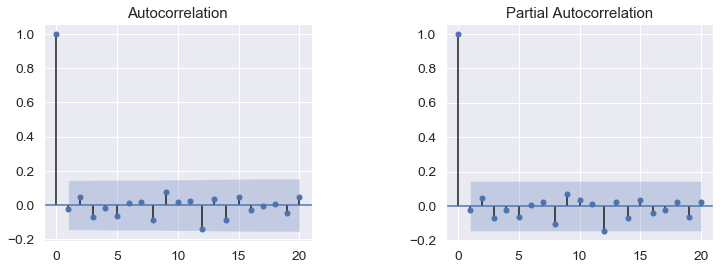

In [41]:
# check that residuals are uncorrelated 
plot_autocorr(arima_results.resid, nlags= 20)

The model produces uncorrelated residuals, and captures the trend in the average energy measured by the submeter as shown in the plot below comparing the fitted values with the actual energy consumption data over the selected time interval. 

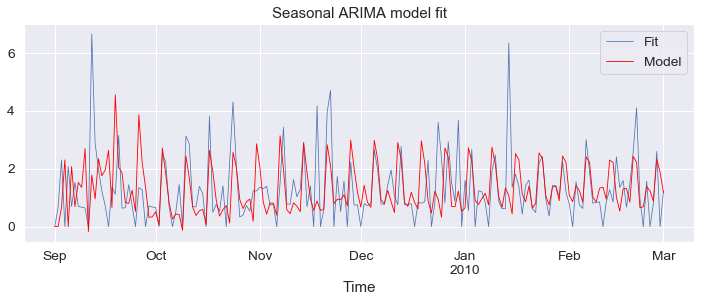

In [42]:
# display series and overlay model fitted values
fig, ax = plt.subplots(1, 1, figsize= (12, 4))
ts.plot(linewidth= 0.75)
fig = arima_results.fittedvalues.plot(ax= ax, color= "red", linewidth= 0.85)
fig = plt.title("Seasonal ARIMA model fit")
fig = ax.axes.legend(["Fit", "Model"])
fig = ax.axes.set_xlabel("Time")

In [43]:
start= "2010-03-01"
end= "2010-03-30"
# make forecasts
predictions = arima_results.get_prediction(start= start, 
                                           end= end, 
                                           dynamic= True)
# calculate confidence intervals
predictions_ci = predictions.conf_int()
# inspect mean values
predictions.predicted_mean.head()

2010-03-01    1.170400
2010-03-02    0.786755
2010-03-03    1.296006
2010-03-04    1.260670
2010-03-05    0.825319
Freq: D, dtype: float64

In [48]:
def plot_model(start, end, 
               timeseries, predicted_values, 
               predicted_ci= None, actual_values= None, 
               title= ""): 
    
    fig, axes = plt.subplots(1, 1, figsize= (12, 4))
    # plot timeseries
    ax = sns.lineplot(data= timeseries)
    # plot actual values
    if actual_values is not None: 
        ax = sns.lineplot(data= actual_values[start:end], color= "blue", linewidth= 0.75)
        ax.lines[1].set_linestyle("-.")
    
    # plot forecasts
    ax= sns.lineplot(data= predicted_values, color= "red", linewidth= 1.0)
    
    # plot confidence intervals
    if predicted_ci is not None: 
        y1= predicted_ci.iloc[:, 0].where(cond= predicted_ci.iloc[:, 0]>0, other= 0)
        y2= predicted_ci.iloc[:, 1]
        x= predicted_values.index
        ax.fill_between(x= x, y1= y1, y2= y2, 
                        alpha=.15, color= "red")
    # add title 
    ax= plt.title(title)

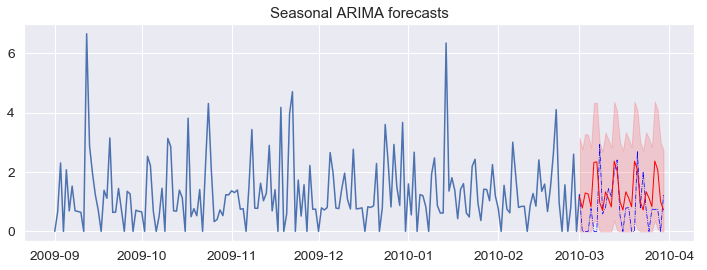

In [49]:
plot_model(start= "2010-03-01", end= "2010-03-30", 
           timeseries= ts, predicted_values= predictions.predicted_mean, 
           predicted_ci= predictions_ci, actual_values= byDay.sub1, 
           title= "Seasonal ARIMA forecasts")

### 4.2 Forecasting with the Holt-Winters Model. 

In [50]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# time series: total energy consumption
ts = byWeek.active_pow.copy() * 1e3/60
# set index frequency
ts = ts.asfreq("W")

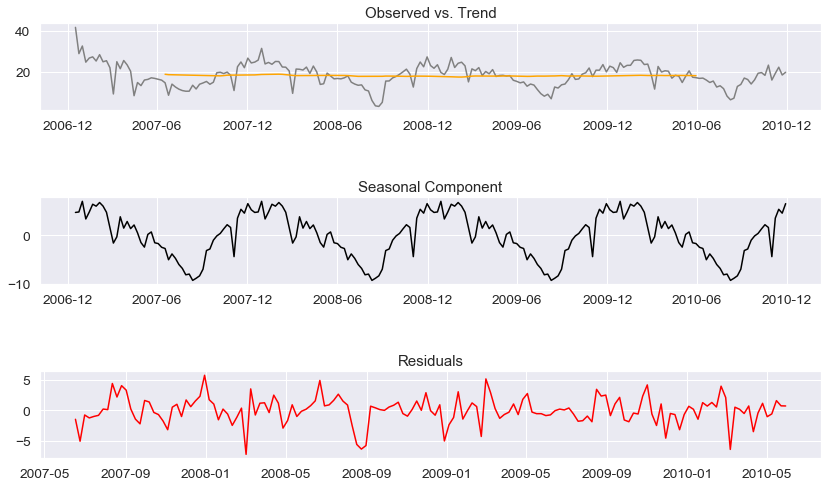

In [51]:
split_and_plot(timeseries= ts, split_type= "additive")

In [52]:
for item in test_df(ts): 
    print(item)

Results of Dickey-Fuller Test:
Test Statistic         -4.289295
p-value                 0.000464
#Lags Used              1.000000
#Observations Used    205.000000
dtype: float64


In [53]:
# instantiate model 
hw_model = ExponentialSmoothing(endog= ts, 
                                trend= None, # stationary series
                                seasonal= "add", # seasonality
                                seasonal_periods= 52) # periods (weeks) in a season (year)
# fit
hw_results = hw_model.fit()

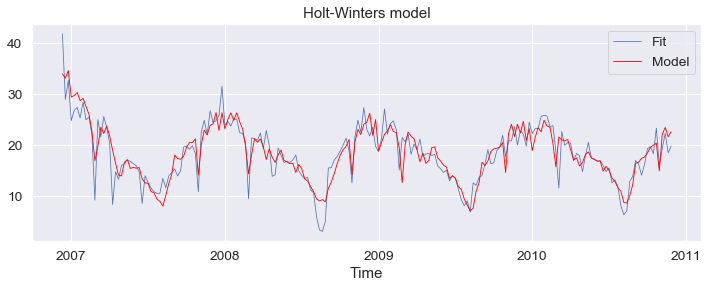

In [54]:
# display series and overlay model fitted values
fig, ax = plt.subplots(1, 1, figsize= (12, 4))
ts.plot(linewidth= 0.75)
fig = hw_results.fittedvalues.plot(ax= ax, color= "red", linewidth= 0.85)
fig = plt.title("Holt-Winters model")
fig = ax.axes.legend(["Fit", "Model"])
fig = ax.axes.set_xlabel("Time")

In [55]:
# make forecasts
start= ts.index[-1] + dt.timedelta(weeks= 1)
end= start + dt.timedelta(weeks= 52)
predictions = hw_results.predict(start, end)

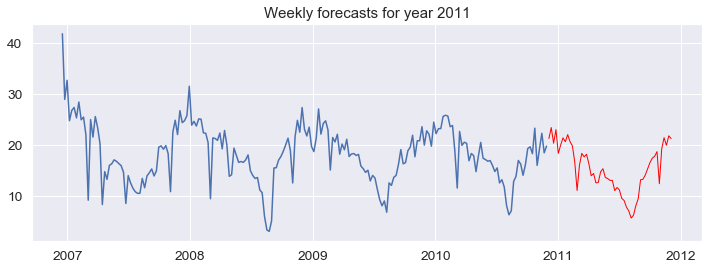

In [56]:
# plot forecasts
plot_model(start= ts.index[0], end= ts.index[-1], 
           timeseries= ts, predicted_values= predictions, 
           title= "Weekly forecasts for year 2011")